### Import necessary libraries

In [43]:
!pip install --upgrade scikit-learn==1.6.1 imbalanced-learn category-encoders numpy==1.26.4 pandas scipy

In [44]:
import pandas as pd
import geopandas as gpd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, Conv1D, Flatten, Input
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KDTree
import matplotlib.pyplot as plt
import seaborn as sns
import os

### Loading Data

In [45]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/geoai-challenge-for-cropland-mapping-dry-dataset/Sentinel2.csv
/kaggle/input/geoai-challenge-for-cropland-mapping-dry-dataset/SampleSubmission.csv
/kaggle/input/geoai-challenge-for-cropland-mapping-dry-dataset/Sentinel1.csv
/kaggle/input/geoai-challenge-for-cropland-mapping-dry-dataset/Test.csv
/kaggle/input/geoai-challenge-for-cropland-mapping-dry-dataset/Train/Orenburg_training_samples.shx
/kaggle/input/geoai-challenge-for-cropland-mapping-dry-dataset/Train/Fergana_training_samples.dbf
/kaggle/input/geoai-challenge-for-cropland-mapping-dry-dataset/Train/Fergana_training_samples.shp
/kaggle/input/geoai-challenge-for-cropland-mapping-dry-dataset/Train/Orenburg_training_samples.dbf
/kaggle/input/geoai-challenge-for-cropland-mapping-dry-dataset/Train/Fergana_training_samples.shx
/kaggle/input/geoai-challenge-for-cropland-mapping-dry-dataset/Train/Orenburg_training_samples.shp


In [46]:
# Load Sentinel-1 and 2
s1 = pd.read_csv("/kaggle/input/geoai-challenge-for-cropland-mapping-dry-dataset/Sentinel1.csv").drop(columns=['date'])
s2 = pd.read_csv("/kaggle/input/geoai-challenge-for-cropland-mapping-dry-dataset/Sentinel2.csv").drop(columns=['date'])

In [47]:
s1.head()

,ID,VH,VV,orbit,polarization,rel_orbit,translated_lat,translated_lon
0,ID_AFQOFP,-21.479683,-16.633259,DESCENDING,"[VV, VH]",78.0,41.652292,72.144256
1,ID_AFQOFP,-24.769110,-15.943674,DESCENDING,"[VV, VH]",78.0,41.652289,72.144375
2,ID_AFQOFP,-25.370838,-15.185609,DESCENDING,"[VV, VH]",78.0,41.652286,72.144495
3,ID_AFQOFP,-24.134005,-16.351102,DESCENDING,"[VV, VH]",78.0,41.652283,72.144614
4,ID_AFQOFP,-20.654249,-16.792723,DESCENDING,"[VV, VH]",78.0,41.652280,72.144733


In [48]:
s2.head()

,B11,B12,B2,B3,B4,B5,B6,B7,B8,B8A,ID,cloud_pct,solar_azimuth,solar_zenith,translated_lat,translated_lon
0,2169,1820,1328,1610,1670,1985,2446,2628,2598,2638,ID_ZHZRHO,6.980395,139.093139,22.625533,40.935173,71.617062
1,2151,1770,1306,1586,1640,1961,2495,2691,2684,2732,ID_ZHZRHO,6.980395,139.093139,22.625533,40.935171,71.617180
2,2169,1820,1456,1674,1808,1985,2446,2628,2486,2638,ID_ZHZRHO,6.980395,139.093139,22.625533,40.935085,71.616940
3,2169,1820,1284,1604,1658,1985,2446,2628,2658,2638,ID_ZHZRHO,6.980395,139.093139,22.625533,40.935083,71.617059
4,2151,1770,1242,1522,1564,1961,2495,2691,2696,2732,ID_ZHZRHO,6.980395,139.093139,22.625533,40.935081,71.617177


### Data Preparation

In [49]:
# shape of sentinel 1 & 2
print('s1 shape:', s1.shape)
print('\n')
print('s2 shape:', s2.shape)

s1 shape: (1752570, 8)


s2 shape: (5610393, 16)


In [50]:
# Sentinel 1 & 2 information
s1.info()
print('-'*50)
s2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1752570 entries, 0 to 1752569
Data columns (total 8 columns):
 #   Column          Dtype  
---  ------          -----  
 0   ID              object 
 1   VH              float64
 2   VV              float64
 3   orbit           object 
 4   polarization    object 
 5   rel_orbit       float64
 6   translated_lat  float64
 7   translated_lon  float64
dtypes: float64(5), object(3)
memory usage: 107.0+ MB
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5610393 entries, 0 to 5610392
Data columns (total 16 columns):
 #   Column          Dtype  
---  ------          -----  
 0   B11             int64  
 1   B12             int64  
 2   B2              int64  
 3   B3              int64  
 4   B4              int64  
 5   B5              int64  
 6   B6              int64  
 7   B7              int64  
 8   B8              int64  
 9   B8A             int64  
 10  ID              object 
 11

In [51]:
# Check null values
print('s1')
print(s1.isna().sum())
print('-'*50)
print('s2')
print(s2.isna().sum())

s1
ID                0
VH                0
VV                0
orbit             0
polarization      0
rel_orbit         0
translated_lat    0
translated_lon    0
dtype: int64
--------------------------------------------------
s2
B11               0
B12               0
B2                0
B3                0
B4                0
B5                0
B6                0
B7                0
B8                0
B8A               0
ID                0
cloud_pct         0
solar_azimuth     0
solar_zenith      0
translated_lat    0
translated_lon    0
dtype: int64


### Extract Labelled GeoData

In [52]:
def load_training_data():
    fergana = gpd.read_file("/kaggle/input/geoai-challenge-for-cropland-mapping-dry-dataset/Train/Fergana_training_samples.shp")
    orenburg = gpd.read_file("/kaggle/input/geoai-challenge-for-cropland-mapping-dry-dataset/Train/Orenburg_training_samples.shp")

    # Do NOT set CRS or convert CRS, just extract coordinates
    # Only calculate centroids if geometry is not already Point
    if not all(fergana.geometry.geom_type == "Point"):
        fergana['geometry'] = fergana.geometry.centroid
    if not all(orenburg.geometry.geom_type == "Point"):
        orenburg['geometry'] = orenburg.geometry.centroid

    fergana['lon'] = fergana.geometry.x
    fergana['lat'] = fergana.geometry.y
    orenburg['lon'] = orenburg.geometry.x
    orenburg['lat'] = orenburg.geometry.y

    gdf = pd.concat([fergana, orenburg])
    print(gdf[['lon', 'lat']].head())
    print("Train lon range:", gdf['lon'].min(), gdf['lon'].max())
    print("Train lat range:", gdf['lat'].min(), gdf['lat'].max())
    return gdf[['Cropland', 'lon', 'lat']]

In [53]:
train_gdf = load_training_data()
print(train_gdf.head())
print("Train lon range:", train_gdf['lon'].min(), train_gdf['lon'].max())
print("Train lat range:", train_gdf['lat'].min(), train_gdf['lat'].max())

         lon        lat
0  71.749080  41.396323
1  72.901429  41.072193
2  72.463988  40.619055
3  72.197317  41.627590
4  71.312037  41.369462
Train lon range: 54.006673861691354 72.9859295922386
Train lat range: 40.00926404600921 52.982225224058766
   Cropland        lon        lat
0         0  71.749080  41.396323
1         0  72.901429  41.072193
2         1  72.463988  40.619055
3         0  72.197317  41.627590
4         0  71.312037  41.369462
Train lon range: 54.006673861691354 72.9859295922386
Train lat range: 40.00926404600921 52.982225224058766


### Feature Engineering

In [54]:
# Robust feature aggregation
def aggregate_features(df, id_col='ID'):
    """Aggregate time-series data using mean and std for numeric columns only"""
    # Convert to numeric and handle errors
    numeric_df = df.copy()
    for col in numeric_df.columns:
        if col != id_col:
            numeric_df[col] = pd.to_numeric(numeric_df[col], errors='coerce')
    
    # Fill any remaining NaNs
    numeric_df = numeric_df.fillna(0)
    
    # Select only numeric columns
    numeric_cols = numeric_df.select_dtypes(include=[np.number]).columns.tolist()
    if id_col not in numeric_cols:
        numeric_cols.append(id_col)
    
    # Group and aggregate
    agg_df = numeric_df[numeric_cols].groupby(id_col).agg(['mean', 'std'])
    
    # Flatten column names
    agg_df.columns = [f'{col[0]}_{col[1]}' for col in agg_df.columns]
    return agg_df.reset_index()

In [55]:
# Feature engineering
def calculate_vegetation_indices(df):
    """Calculate vegetation indices"""
    # Convert to numeric
    for band in ['B2', 'B3', 'B4', 'B8', 'B11']:
        df[band] = pd.to_numeric(df[band], errors='coerce')
    
    df['NDVI'] = (df['B8'] - df['B4']) / (df['B8'] + df['B4'] + 1e-8)
    df['NDWI'] = (df['B3'] - df['B8']) / (df['B3'] + df['B8'] + 1e-8)
    return df

In [56]:
# Load training data
train_gdf = load_training_data()
print(f"Loaded {len(train_gdf)} training samples")

         lon        lat
0  71.749080  41.396323
1  72.901429  41.072193
2  72.463988  40.619055
3  72.197317  41.627590
4  71.312037  41.369462
Train lon range: 54.006673861691354 72.9859295922386
Train lat range: 40.00926404600921 52.982225224058766
Loaded 1000 training samples


In [57]:
# Process Sentinel-2 data
s2 = calculate_vegetation_indices(s2)
print("Sentinel-2 columns:", s2.columns.tolist())
s2_agg = aggregate_features(s2)

Sentinel-2 columns: ['B11', 'B12', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'ID', 'cloud_pct', 'solar_azimuth', 'solar_zenith', 'translated_lat', 'translated_lon', 'NDVI', 'NDWI']


In [58]:
# Process Sentinel-1 data
print("\nSentinel-1 columns:", s1.columns.tolist())


Sentinel-1 columns: ['ID', 'VH', 'VV', 'orbit', 'polarization', 'rel_orbit', 'translated_lat', 'translated_lon']


In [59]:
# Convert Sentinel-1 to numeric
for col in ['VV', 'VH']:
    s1[col] = pd.to_numeric(s1[col], errors='coerce')
s1 = s1.fillna(0)

In [60]:
s1_agg = aggregate_features(s1)
print("\nSentinel-1 aggregated columns:", s1_agg.columns.tolist())


Sentinel-1 aggregated columns: ['ID', 'VH_mean', 'VH_std', 'VV_mean', 'VV_std', 'orbit_mean', 'orbit_std', 'polarization_mean', 'polarization_std', 'rel_orbit_mean', 'rel_orbit_std', 'translated_lat_mean', 'translated_lat_std', 'translated_lon_mean', 'translated_lon_std']


#### Merge satellite data

In [61]:
# Merge satellite data
satellite_data = pd.merge(s2_agg, s1_agg, on='ID', how='inner')
print(f"\nMerged satellite data shape: {satellite_data.shape}")


Merged satellite data shape: (600, 49)


In [62]:
# Get mean coordinates
coords = s2.groupby('ID')[['translated_lon', 'translated_lat']].mean().reset_index()

In [63]:
# Check if satellite coordinates are in UTM range (large numbers)
if coords['translated_lon'].max() > 180 or coords['translated_lat'].max() > 90:
    print("Converting satellite coordinates to WGS84...")
    
    # Create UTM geometry (assuming zone 40 for Fergana, 41 for Orenburg)
    from pyproj import Transformer
    
    # Transform UTM to WGS84
    transformer = Transformer.from_crs("EPSG:32640", "EPSG:4326", always_xy=True)  # Orenburg
    # For Fergana use EPSG:32642
    
    # Apply transformation
    wgs84_coords = []
    for _, row in coords.iterrows():
        # Check which zone it belongs to based on position
        if row['translated_lon'] > 500000:  # UTM Easting
            # Orenburg zone (EPSG:32640)
            lon, lat = transformer.transform(row['translated_lon'], row['translated_lat'])
        else:
            # Fergana zone (EPSG:32642)
            lon, lat = transformer.transform(row['translated_lon'], row['translated_lat'])
        wgs84_coords.append([lon, lat])
    
    coords[['lon_wgs84', 'lat_wgs84']] = np.array(wgs84_coords)
    # Use converted coordinates for matching
    coords['translated_lon'] = coords['lon_wgs84']
    coords['translated_lat'] = coords['lat_wgs84']

In [64]:
# Check coordinate ranges
print("Train sample:", train_gdf[['lon', 'lat']].head())
print("Test sample:", coords[['translated_lon', 'translated_lat']].head())

Train sample:          lon        lat
0  71.749080  41.396323
1  72.901429  41.072193
2  72.463988  40.619055
3  72.197317  41.627590
4  71.312037  41.369462
Test sample:    translated_lon  translated_lat
0       72.849372       41.510684
1       71.910871       41.380469
2       72.190803       40.769864
3       72.144468       41.652098
4       54.717736       51.641874


In [65]:
print("Train coordinates sample:")
print(train_gdf[['lon', 'lat']].head())
print("Train lon range:", train_gdf['lon'].min(), train_gdf['lon'].max())
print("Train lat range:", train_gdf['lat'].min(), train_gdf['lat'].max())

print("Test coordinates sample:")
print(coords[['translated_lon', 'translated_lat']].head())
print("Test lon range:", coords['translated_lon'].min(), coords['translated_lon'].max())
print("Test lat range:", coords['translated_lat'].min(), coords['translated_lat'].max())

Train coordinates sample:
         lon        lat
0  71.749080  41.396323
1  72.901429  41.072193
2  72.463988  40.619055
3  72.197317  41.627590
4  71.312037  41.369462
Train lon range: 54.006673861691354 72.9859295922386
Train lat range: 40.00926404600921 52.982225224058766
Test coordinates sample:
   translated_lon  translated_lat
0       72.849372       41.510684
1       71.910871       41.380469
2       72.190803       40.769864
3       72.144468       41.652098
4       54.717736       51.641874
Test lon range: 54.26461772506346 73.2074963114073
Test lat range: 40.27936508234601 53.23875936888679


In [66]:
# Increase threshold
MAX_DIST = 0.5 

# Re-run KDTree matching
tree = KDTree(train_gdf[['lon', 'lat']].values)
distances, indices = tree.query(coords[['translated_lon', 'translated_lat']].values, k=1)
valid_mask = distances.flatten() <= MAX_DIST

labels = pd.DataFrame({
    'ID': coords['ID'],
    'label': np.where(valid_mask, train_gdf.iloc[indices.flatten()]['Cropland'].values, -1),
    'distance': distances.flatten()
})

In [67]:
# Filter valid labels
valid_labels = labels[labels['label'] != -1].drop(columns='distance')
print(f"Matched {len(valid_labels)}/{len(coords)} points to training labels")

# Merge features with labels
full_data = pd.merge(satellite_data, valid_labels, on='ID')
print(f"Final dataset size: {full_data.shape}")

Matched 600/600 points to training labels
Final dataset size: (600, 50)


In [68]:
full_data.head()

,ID,B11_mean,B11_std,B12_mean,B12_std,B2_mean,B2_std,B3_mean,B3_std,B4_mean,...,orbit_std,polarization_mean,polarization_std,rel_orbit_mean,rel_orbit_std,translated_lat_mean_y,translated_lat_std_y,translated_lon_mean_y,translated_lon_std_y,label
0,ID_ABQOQT,4006.207245,948.806093,3214.522401,699.895483,2678.931516,2533.538818,3087.956733,2446.428918,3313.985663,...,0.0,0.0,0.0,5.000000,0.000000,41.510673,0.000134,72.849369,0.000178,0
1,ID_ADDROF,3616.306531,657.104319,3288.943469,612.300262,2180.467148,793.942887,2551.151900,745.784220,2725.154697,...,0.0,0.0,0.0,40.942498,36.498475,41.380478,0.000134,71.910860,0.000178,0
2,ID_AFIWZH,3011.973886,594.528719,2534.593781,591.611468,1760.097410,735.938649,2015.750320,689.742879,2055.006831,...,0.0,0.0,0.0,41.150613,36.501058,40.769855,0.000134,72.190805,0.000177,1
3,ID_AFQOFP,4174.708865,970.557707,3533.380821,834.848863,2459.410762,1700.451288,2913.663884,1596.009589,3316.157296,...,0.0,0.0,0.0,41.857791,36.500917,41.652106,0.000134,72.144470,0.000178,0
4,ID_AHRONV,3161.708739,960.517873,2645.720038,721.858187,2965.180911,3141.400874,3160.444765,2983.807369,3339.176704,...,0.0,0.0,0.0,57.065246,33.546779,51.641876,0.000133,54.717738,0.000214,0


In [69]:
# Train-test split
X = full_data.drop(columns=["ID", "label"])
y = full_data["label"]
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [92]:
# Find common columns between train and test
common_cols = list(set(X_train.columns) & set(X_test.columns))
print("Using only columns present in both train and test:", common_cols)

# Subset all sets to these columns
X_train = X_train[common_cols]
X_val = X_val[common_cols]
X_test = X_test[common_cols]

Using only columns present in both train and test: ['NDVI_mean', 'NDVI_std', 'B2_mean', 'B4_mean', 'NDWI_mean', 'B3_mean', 'VV_std', 'B12_std', 'B5_mean', 'NDWI_std', 'B8A_mean', 'VV_mean', 'B11_std', 'B3_std', 'B8_mean', 'B8_std', 'B4_std', 'B2_std', 'B11_mean', 'VH_mean', 'B12_mean', 'B7_std', 'B5_std', 'B6_std', 'B8A_std', 'B7_mean', 'VH_std', 'B6_mean']


### CNN Model

In [99]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Reshape for CNN: (samples, features, 1)
X_train_cnn = np.expand_dims(X_train_scaled, axis=2)
X_val_cnn = np.expand_dims(X_val_scaled, axis=2)

# Encode labels for categorical crossentropy
num_classes = len(np.unique(y_train))
y_train_cnn = to_categorical(y_train, num_classes)
y_val_cnn = to_categorical(y_val, num_classes)

# Build the CNN model
model = Sequential([
    Input(shape=(X_train_cnn.shape[1], 1)),
    Conv1D(32, kernel_size=3, activation='relu'),
    Dropout(0.2),
    Conv1D(64, kernel_size=3, activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [103]:
# 5. Save the best model during training
checkpoint = ModelCheckpoint('best_cnn_model.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

# 6. Train the model
history = model.fit(
    X_train_cnn, y_train_cnn,
    epochs=30,
    batch_size=32,
    validation_data=(X_val_cnn, y_val_cnn),
    callbacks=[checkpoint],
    verbose=2
)

# 7. Load the best weights before evaluation
model.load_weights('best_cnn_model.h5')

Epoch 1/30

Epoch 1: val_accuracy improved from -inf to 0.68333, saving model to best_cnn_model.h5
15/15 - 0s - 11ms/step - accuracy: 0.6979 - loss: 0.5777 - val_accuracy: 0.6833 - val_loss: 0.6034
Epoch 2/30

Epoch 2: val_accuracy improved from 0.68333 to 0.69167, saving model to best_cnn_model.h5
15/15 - 0s - 8ms/step - accuracy: 0.6896 - loss: 0.5692 - val_accuracy: 0.6917 - val_loss: 0.6099
Epoch 3/30

Epoch 3: val_accuracy did not improve from 0.69167
15/15 - 0s - 7ms/step - accuracy: 0.6792 - loss: 0.5651 - val_accuracy: 0.6667 - val_loss: 0.6029
Epoch 4/30

Epoch 4: val_accuracy did not improve from 0.69167
15/15 - 0s - 7ms/step - accuracy: 0.6708 - loss: 0.5735 - val_accuracy: 0.6250 - val_loss: 0.6226
Epoch 5/30

Epoch 5: val_accuracy did not improve from 0.69167
15/15 - 0s - 7ms/step - accuracy: 0.6917 - loss: 0.5683 - val_accuracy: 0.6750 - val_loss: 0.6019
Epoch 6/30

Epoch 6: val_accuracy did not improve from 0.69167
15/15 - 0s - 7ms/step - accuracy: 0.6854 - loss: 0.5679 

In [104]:
# Evaluate on validation set
val_loss, val_acc = model.evaluate(X_val_cnn, y_val_cnn, verbose=0)
print("Validation Accuracy:", val_acc)

Validation Accuracy: 0.7083333134651184


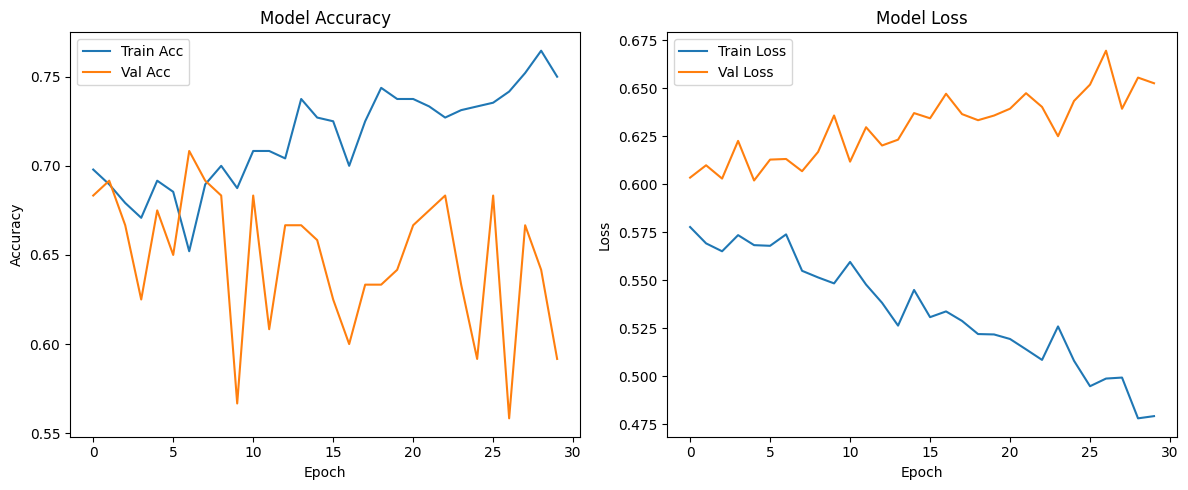

In [105]:
# Plot training & validation accuracy and loss
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')

plt.tight_layout()
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


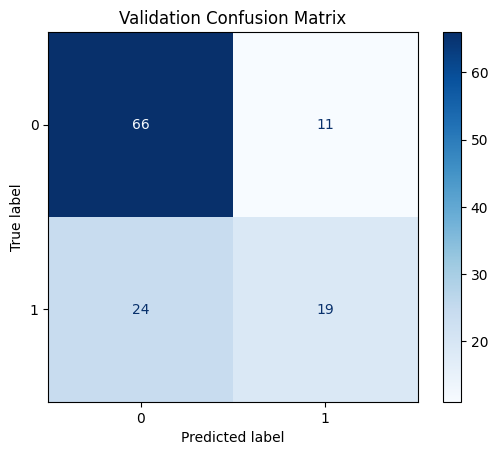

In [106]:
# Predict on validation set
y_val_pred = np.argmax(model.predict(X_val_cnn), axis=1)
cm = confusion_matrix(np.argmax(y_val_cnn, axis=1), y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Validation Confusion Matrix')
plt.show()

In [107]:
# Prepare test meta and filter Sentinel data
test_meta = pd.read_csv("/kaggle/input/geoai-challenge-for-cropland-mapping-dry-dataset/Test.csv")
test_ids = test_meta["ID"].unique()
s1_test = s1[s1["ID"].isin(test_ids)]
s2_test = s2[s2["ID"].isin(test_ids)]

# Apply all feature engineering to test set
s2_test = calculate_vegetation_indices(s2_test)

# Aggregate features for test set
s1_test_feats = aggregate_features(s1_test[["ID", "VH", "VV"]])
s2_test_feats = aggregate_features(
    s2_test[["ID", "B2", "B3", "B4", "B5", "B6", "B7", "B8", "B8A", "B11", "B12", "NDVI", "NDWI"]]
)

# Ensure 'ID' is a column
if 'ID' not in s1_test_feats.columns:
    s1_test_feats = s1_test_feats.reset_index()
if 'ID' not in s2_test_feats.columns:
    s2_test_feats = s2_test_feats.reset_index()

# Merge features
test_df = pd.merge(s2_test_feats, s1_test_feats, on="ID", how="outer").fillna(0)
X_test = test_df.drop(columns=["ID"])

# Drop all-zero columns from train/val/test 
zero_cols = [col for col in X_test.columns if X_test[col].sum() == 0]
print("Dropping all-zero columns from train/val/test:", zero_cols)

X_train = X_train.drop(columns=zero_cols)
X_val = X_val.drop(columns=zero_cols)
X_test = X_test.drop(columns=zero_cols)

# Align columns 
X_test = X_test[X_train.columns]

# Scale and predict
X_test_scaled = scaler.transform(X_test)
X_test_cnn = np.expand_dims(X_test_scaled, axis=2)
test_preds = model.predict(X_test_cnn)

Dropping all-zero columns from train/val/test: []
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


#### Apply All Feature Engineering to Test Set

In [108]:
# Save predictions to CSV
predicted_labels = np.argmax(test_preds, axis=1)
submission = pd.DataFrame({'ID': test_df['ID'], 'label': predicted_labels})
submission.to_csv('submission.csv', index=False)

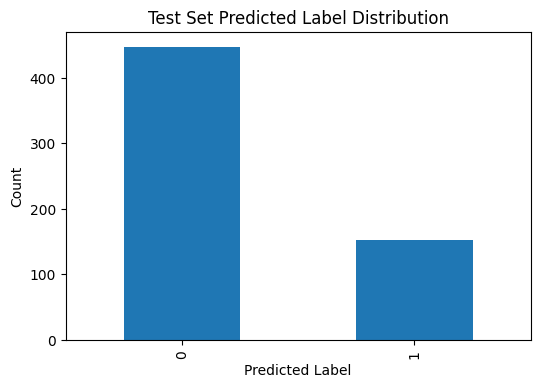

In [109]:
plt.figure(figsize=(6,4))
submission['label'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Predicted Label')
plt.ylabel('Count')
plt.title('Test Set Predicted Label Distribution')
plt.show()

In [110]:
print(X_test.describe())
print((X_test == 0).sum())

        NDVI_mean    NDVI_std      B2_mean      B4_mean   NDWI_mean  \
count  600.000000  600.000000   600.000000   600.000000  600.000000   
mean     0.198601    0.151181  2576.786660  2898.241984   -0.228168   
std      0.083818    0.057049   764.506547   734.433856    0.069598   
min     -0.091128    0.016844  1160.569411  1081.271431   -0.462662   
25%      0.147153    0.117452  1890.424302  2277.918774   -0.268746   
50%      0.178412    0.153340  2533.353603  2953.432775   -0.216729   
75%      0.251746    0.190739  3171.538776  3419.112786   -0.193010   
max      0.469320    0.284924  6829.087494  6709.184453    0.198311   

           B3_mean      VV_std      B12_std      B5_mean    NDWI_std  ...  \
count   600.000000  600.000000   600.000000   600.000000  600.000000  ...   
mean   2774.861370    3.248547   782.837321  3206.425591    0.147483  ...   
std     695.099306    0.782760   171.603740   688.229645    0.046907  ...   
min    1299.514899    1.808987   424.172812  1102.52

In [111]:
print(y_train.value_counts())

label
0    308
1    172
Name: count, dtype: int64


In [112]:
y_val_pred = np.argmax(model.predict(X_val_cnn), axis=1)
print(np.unique(y_val_pred, return_counts=True))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
(array([0, 1]), array([90, 30]))
